<a href="https://colab.research.google.com/github/tillu1208/OpenCV/blob/main/19_01_text_detection_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style=\"font-size:30px;\">Text Detection in Natural Scenes</h1>

Text detection is one of the most used applications of computer vision. "Scene Text Detection" is the process of detecting the presence and position of text in an image. **Be aware!** This is distinct and different from actually interpreting the letters and words written, called "Text Recognition", which we will cover in the subsequent notebook.

With the increasing use of cameras you can find applications of text detection almost everywhere. Use it for boothless tolls (detecting number plates), equipping robots with it in hazardous environments, or even increasing accessibility for the blind and visually impaired.

<hr style="border:2px solid gray"> </hr>

## Goal

<br>
<center>
<img src='https://opencv.org/wp-content/uploads/2021/10/co-m19-demo-result.png' alt="demo-result-text-detection">
</center>
<br>
We will discuss about two algorithms available in OpenCV for Text Detection. Both algorithms use Deep Learning for detecting text.

1. [EAST: An Efficient and Accurate Scene Text Detector](https://arxiv.org/pdf/1704.03155.pdf)
2. [Real-time Scene Text Detection with Differentiable Binarization](https://arxiv.org/pdf/1911.08947.pdf)

**EAST** was a really fast algorithm from CVPR-2017, while **DB** is a more recent algorithm that was accepted in AAAI-2020 and is more accurate and robust.

In [ ]:
if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/2am8d2yn4xrzk9i/AAAiJEQuwzAysEe6jNUGuCH4a?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
    !pip install --upgrade opencv-contrib-python
else:
    pass

In [ ]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import Image

plt.rcParams['image.cmap'] = 'gray'

# 1. Display Image to be used

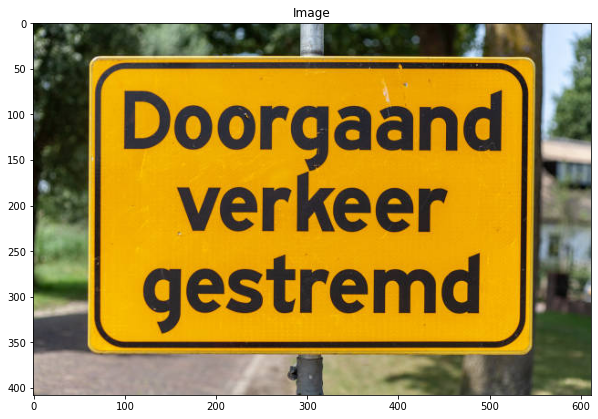

In [ ]:
# Load Image
image = cv2.imread('./visuals/dutch_signboard.jpg')
# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(image[:, :, ::-1]); plt.title('Image');

# 2. Load text detection pretrained models

## 2.1 Import the prebuilt text detection and text recognition model files

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font color="green">OpenCV Documentation</font>

For the text detection in the image, we will be trying out both the East text and DB text detection models. Both text detectors are neural network based models that have been trained using images containing words. It returns the (x,y) coordinates of vertices of ROI containing the text as its output.

[**`dnn_TextDetectionModel_EAST()`**](https://docs.opencv.org/master/d8/ddc/classcv_1_1dnn_1_1TextDetectionModel__EAST.html)<br>
[**`dnn_TextDetectionModel_DB()`**](https://docs.opencv.org/master/db/d0f/classcv_1_1dnn_1_1TextDetectionModel__DB.html)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### Set the input Image Size

This is a very important parameter for text detection. If you are not getting desired results, it might be because the text is too small to be detected. If speed is not a concern, then you can increase the input size to get better results.

In [ ]:
inputSize = (320, 320)

### Load and initialize the EAST Model
[**`East Text Detection Model()`**](https://docs.opencv.org/master/d8/ddc/classcv_1_1dnn_1_1TextDetectionModel__EAST.html)    

This is the algorithm hailing from 2017. Load the model and initialize the parameters (specifically the thresholds).

You can find more info on the parameters from the [original repo's model code](https://github.com/argman/EAST/blob/master/model.py)

Also check out the demo code provided in [OpenCV Tutorials](https://github.com/opencv/opencv/blob/master/doc/tutorials/dnn/dnn_text_spotting/dnn_text_spotting.markdown)

Load the model and initialize the parameters (specifically the thresholds)

In [ ]:
# East model for text-detection
textDetectorEAST = cv2.dnn_TextDetectionModel_EAST("./resources/frozen_east_text_detection.pb")

# Set the Detection Confidence Threshold and NMS threshold
conf_thresh = 0.8
nms_thresh = 0.4

textDetectorEAST.setConfidenceThreshold(conf_thresh).setNMSThreshold(nms_thresh)
textDetectorEAST.setInputParams(1.0, inputSize, (123.68, 116.78, 103.94), True)

### Load and initialize the DB Model

We can load and prepare the more recent 2020 model, and compare two different trained variants. Resnet50 and resnet18 represent the same architecture but containing 50 and 18 neural network layers respectively. This means that we should expect the 50-layer model to be more accurate, and the 18-layer model to be faster.

[**`DB Text Detection Model()`**](https://docs.opencv.org/master/db/d0f/classcv_1_1dnn_1_1TextDetectionModel__DB.html)

You can find more info on the parameters from the [original repo's demo code](https://github.com/MhLiao/DB/blob/master/demo.py)

Also check out the demo code provided in [OpenCV Tutorials](https://github.com/opencv/opencv/blob/master/doc/tutorials/dnn/dnn_text_spotting/dnn_text_spotting.markdown)

In [ ]:
# DB model for text-detection based on resnet50
textDetectorDB50 = cv2.dnn_TextDetectionModel_DB("./resources/DB_TD500_resnet50.onnx")
# DB model for text-detection based on resnet18
textDetectorDB18 = cv2.dnn_TextDetectionModel_DB("./resources/DB_TD500_resnet18.onnx")

# Set threshold for Binary Map creation and polygon detection
bin_thresh = 0.3
poly_thresh = 0.5

mean = (122.67891434, 116.66876762, 104.00698793)

textDetectorDB18.setBinaryThreshold(bin_thresh).setPolygonThreshold(poly_thresh)
textDetectorDB18.setInputParams(1.0/255, inputSize, mean, True)

textDetectorDB50.setBinaryThreshold(bin_thresh).setPolygonThreshold(poly_thresh)
textDetectorDB50.setInputParams(1.0/255, inputSize, mean, True)

In [ ]:
# Making copies of the original image
imEAST = image.copy()
imDB18 = image.copy()
imDB50 = image.copy()

## 2.2 Use the loaded Text Detectors on the image

We will use the detectors to detect text on the sample images. The detector returns the list of bounding boxes for each detected text along with a list of corresponding confidence scores.

In [ ]:
# Use the East text detector to detect the presence of text in the image
boxesEAST, confsEAST = textDetectorEAST.detect(image)

# Use the DB18 text detector to detect the presence of text in the image
boxesDB18, confsDB18 = textDetectorDB18.detect(image)

# Use the DB50 text detector to detect the presence of text in the image
boxesDB50, confsDB50 = textDetectorDB50.detect(image)

In [ ]:
# Inspect the output of one of the detected text boxes
print(boxesEAST[0])

[[157 230]
 [156 176]
 [450 172]
 [451 227]]


## 2.3 Draw the detected bounding boxes on roi

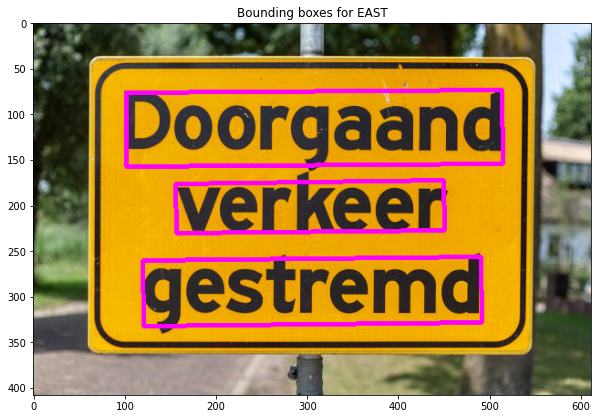

In [ ]:
# Draw the bounding boxes of text detected using EAST.
cv2.polylines(imEAST, boxesEAST, isClosed=True, color=(255, 0, 255), thickness=4)

#Display the image with the bounding boxes drawn
plt.figure(figsize=(10,8))
plt.imshow(imEAST[:, :, ::-1]); plt.title('Bounding boxes for EAST');


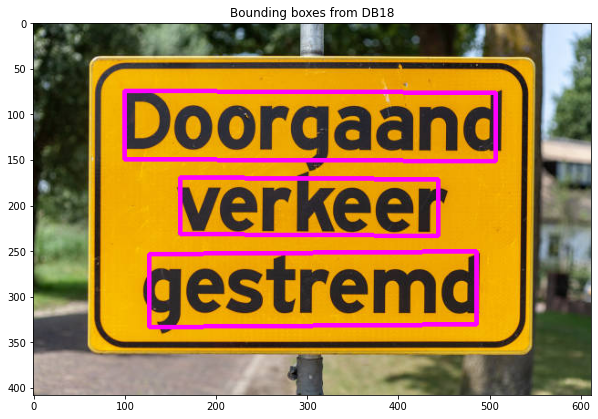

In [ ]:
# Draw the bounding boxes of text detected using DB18.
cv2.polylines(imDB18, boxesDB18, True, (255, 0, 255), 4)

#Display the image with the bounding boxes drawn
plt.figure(figsize=(10, 8))
plt.imshow(imDB18[:, :, ::-1]); plt.title('Bounding boxes from DB18');


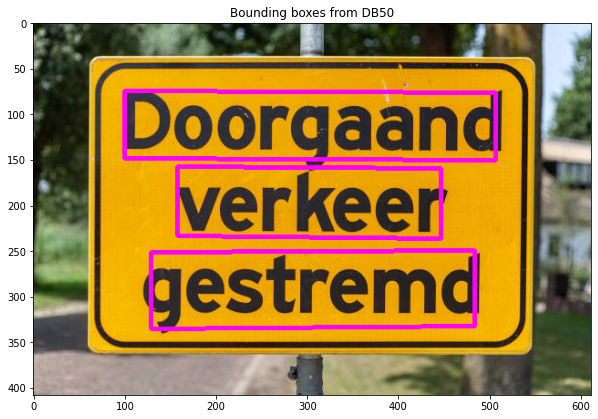

In [ ]:
# Draw the bounding boxes of text detected using DB50.
cv2.polylines(imDB50, boxesDB50, True, (255, 0, 255), 4)

#Display the image with the bounding boxes drawn
plt.figure(figsize=(10,8))
plt.imshow(imDB50[:,:,::-1]); plt.title('Bounding boxes from DB50');


# 3. Display a combined output (for comparison)

To better understand how the approaches compare, we will try to show the original image and the outputs of the 3 different methods all in a single row. This will let us more intuitively see how effectively each algorithm is at detecting all words in the scene.

## 3.1 Preview multiple outputs at once

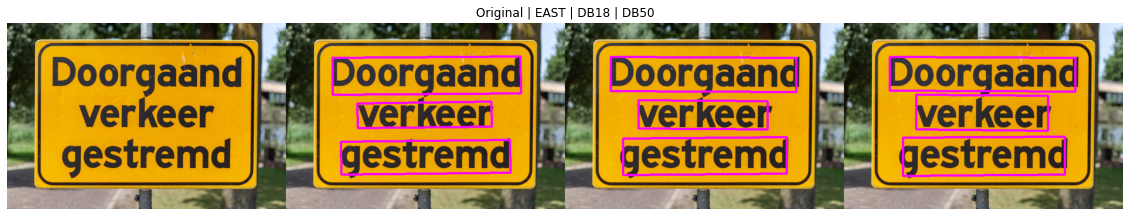

In [ ]:
output = cv2.hconcat([image, imEAST, imDB18, imDB50])
cv2.imwrite('./visuals/english_signboard_detected.jpg', output)

# Display the output Image
plt.figure(figsize=(20, 10))
plt.imshow(output[:, :, ::-1]); plt.title('Original | EAST | DB18 | DB50')
plt.axis("off")
plt.savefig("result.jpg")

## 3.2 Define a reusable function

In [ ]:
def detectTextAll(image):
    """Performs each type of text detection over an image and displays all results side by side."""
    # Making copies of the original image
    imEAST = image.copy()
    imDB18 = image.copy()
    imDB50 = image.copy()

    # Use each text detector to detect the presence of text in the image
    boxesEAST, confsEAST = textDetectorEAST.detect(image)
    boxesDB18, confsDB18 = textDetectorDB18.detect(image)
    boxesDB50, confsDB50 = textDetectorDB50.detect(image)

    # Draw the bounding boxes onto the respective copies of the original image.
    cv2.polylines(imEAST, boxesEAST, True, (255, 0, 255), 4)
    cv2.polylines(imDB18, boxesDB18, True, (255, 0, 255), 4)
    cv2.polylines(imDB50, boxesDB50, True, (255, 0, 255), 4)

    output = cv2.hconcat([image, imEAST, imDB18, imDB50])
    # Display the output image
    plt.figure(figsize=(20,10))
    plt.imshow(output[:, :, ::-1]); plt.title('Original | EAST | DB18 | DB50')


### 3.3 Showing some other examples

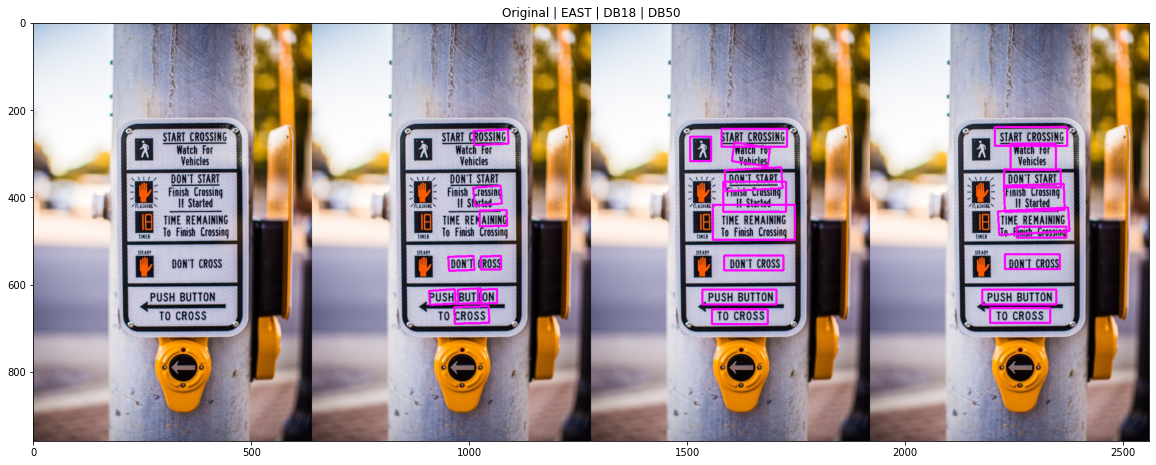

In [ ]:
img1 = cv2.imread('./visuals/traffic1.jpg')
detectTextAll(img1)

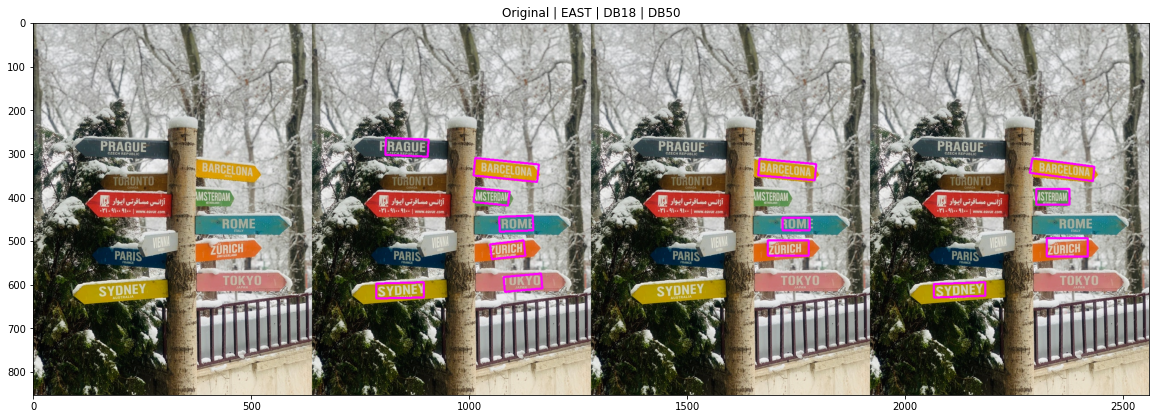

In [ ]:
img2 = cv2.imread('./visuals/traffic2.jpg')
detectTextAll(img2)

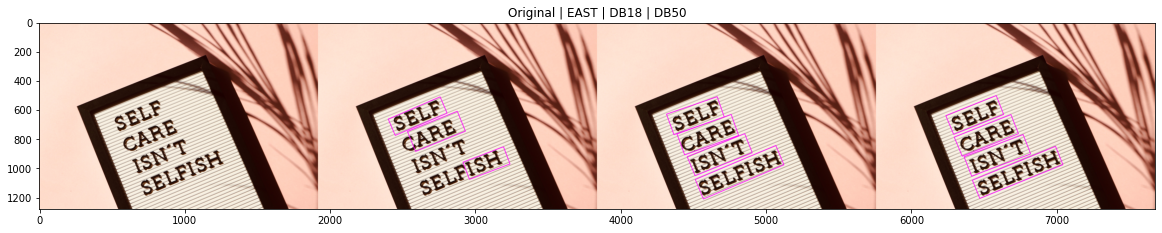

In [ ]:
img3 = cv2.imread('./visuals/card.jpg')
detectTextAll(img3)

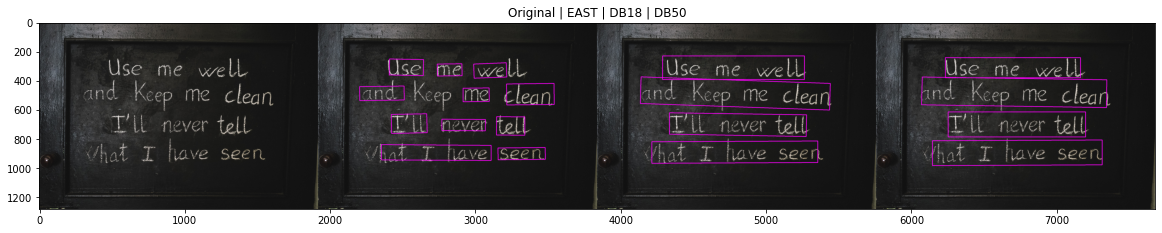

In [ ]:
img4 = cv2.imread('./visuals/Board.jpg')
detectTextAll(img4)

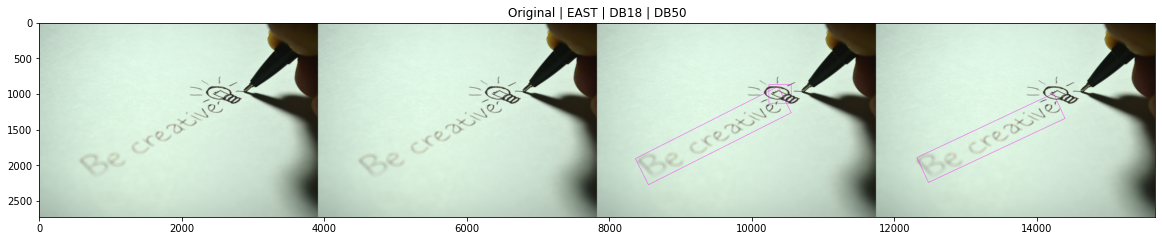

In [ ]:
img5 = cv2.imread('./visuals/paper.jpg')
detectTextAll(img5)

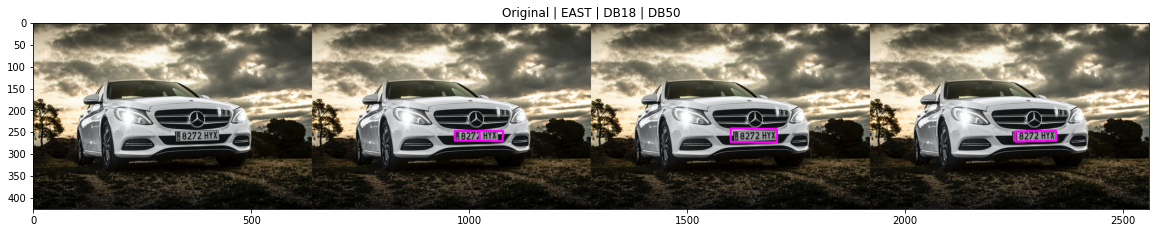

In [ ]:
img6 = cv2.imread('./visuals/car.jpg')
detectTextAll(img6)

Notice how in this last example, the EAST text detector is unable to detect any text!

# 4. Runtime Comparison for EAST vs DB

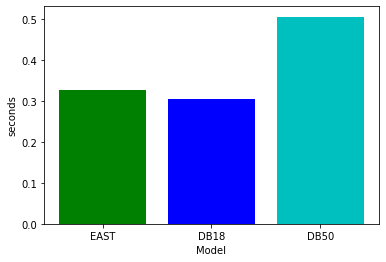

In [ ]:
# Use the East text detector
totalEAST = 0
totalDB18 = 0
totalDB50 = 0

iterations = 10
for i in range(iterations):
    timeEAST = time.time()
    result = textDetectorEAST.detect(img4)
    totalEAST += time.time() - timeEAST

    timeDB18 = time.time()
    result = textDetectorDB18.detect(img4)
    totalDB18 += time.time() - timeDB18

    timeDB50 = time.time()
    result = textDetectorDB50.detect(img4)
    totalDB50 += time.time() - timeDB50

avgEAST = totalEAST / iterations
avgDB18 = totalDB18 / iterations
avgDB50 = totalDB50 / iterations

plt.bar(['EAST', 'DB18', 'DB50'], [avgEAST, avgDB18, avgDB50], color = ['g', 'b', 'c'])
plt.ylabel("seconds")
plt.xlabel("Model")
plt.show()

Once you have detected the presence/location of the text, you must be curious to know whether you can read what's written as well! In the next Notebook, we will discuss about how to recognize the text, also known as Text Recognition.

## Exercise

As seen in the results, there are some failure cases. See if changing the input Size changes the results and if yes, then how much improvement is achieved.